<a href="https://colab.research.google.com/github/anas-awadalla/Incepto/blob/master/interpretability_experiments/Resnet_18_FAISS_Product_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/huyvnphan/PyTorch_CIFAR10.git

Cloning into 'PyTorch_CIFAR10'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 560 (delta 2), reused 4 (delta 2), pack-reused 551
Receiving objects: 100% (560/560), 6.55 MiB | 4.17 MiB/s, done.
Resolving deltas: 100% (184/184), done.


In [ ]:
# !python /content/cifar10_download.py

100% 2.46G/2.46G [03:33<00:00, 11.5MMiB/s]
Download successful. Unzipping file.
Unzip file successful!


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
torch.cuda.set_device(0)

In [2]:
from tqdm.notebook import tqdm
images = []
features = []
trans = transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

dataset_imgs = torchvision.datasets.CIFAR10("/data/",download=True,train=False,transform=trans)
dataloader_imgs = torch.utils.data.DataLoader(dataset_imgs, batch_size=1)


toPil = transform=transforms.Compose([
        transforms.ToPILImage()
    ])

imgs = torchvision.datasets.CIFAR10("/data/",download=True,train=False,transform=transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor()
        ]))
imgs = torch.utils.data.DataLoader(imgs, batch_size=1)



Files already downloaded and verified
Files already downloaded and verified


In [3]:
from PyTorch_CIFAR10.cifar10_models import *

# Pretrained model
model = resnet18(pretrained=True)
model.eval().cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

tensor([[2.1114e-03, 6.9757e-05, 3.4759e-03, 1.8843e-01, 2.0329e-02, 7.2110e-01,
         5.0108e-04, 2.6061e-04, 6.3138e-02, 5.8486e-04]],
       grad_fn=<SoftmaxBackward>)
Output:  5


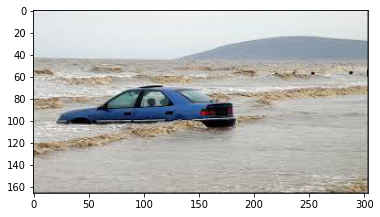

In [4]:
from matplotlib.pyplot import imshow
from PIL import Image
image_path = "/content/car.png" #@param {type: "string"}
ood_img = Image.open(image_path) 

ood_tensor_img = trans(ood_img)

model.cpu().eval()
output = model(ood_tensor_img.unsqueeze(0))
print(torch.softmax(output,dim = 1))
print("Output: ", torch.argmax(output).item())
imshow(ood_img)

Get Convolutional Layers

In [5]:
model_children = list(model.children())
model_weights = []
conv_layers = []

# counter to keep count of the conv layers
counter = 0 

# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 17


In [9]:
!pip install torchray

     |████████████████████████████████| 378kB 2.5MB/s 
  Created wheel for torchray: filename=torchray-1.0.0.2-cp36-none-any.whl size=444028 sha256=4346caddd77a318a6e189e641df364e4dcb358b921db52baf09047c9012c6064
  Stored in directory: /root/.cache/pip/wheels/49/21/6d/e6794f79658b66a0775b164fdd274b81a4c96e4eab5baaacb0
Successfully built torchray


In [6]:
from torchray.attribution.extremal_perturbation import extremal_perturbation, contrastive_reward
from torchvision.utils import save_image
import cv2
# from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

img_to_tensor = transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()])

def perturbation(x,img,y, path, area=0.1):
  # Extremal perturbation
      masks_1,_ = extremal_perturbation(
          model.cuda(), x.cuda(), y,
          reward_func=contrastive_reward,
          perturbation="blur",
          debug=False,
          areas=[area],
          smooth=0.01,
          max_iter=800
      )
      ## Crop Important Area
      dat=torch.round(masks_1)[0].cpu().detach().numpy() # 'sharpen' mask
      true_points = np.argwhere(dat)

      # take the smallest points and use them as the top left of your crop
      top_left = true_points.min(axis=0)
      # take the largest points and use them as the bottom right of your crop
      bottom_right = true_points.max(axis=0)

      img = img_to_tensor(img)

      save_image(img,path)
        
      img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

      start_point = (top_left[1], top_left[2]) 
      end_point = (bottom_right[1], bottom_right[2]) 


      color = (255, 0, 0) 
      thickness = 2
      img = cv2.rectangle(img, start_point, end_point, (255, 0, 0), thickness)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # cv2.imwrite("img1.png",np.asarray(x))
      plt.imsave(path,img)
       

In [8]:
perturbation(ood_tensor_img.unsqueeze(0),ood_img,4,"output_imgs/original.png")

In [14]:
!pip install faiss-cpu

     |████████████████████████████████| 7.2MB 2.5MB/s 


In [7]:
import numpy as np
import faiss

In [8]:
images = []
for img, _ in tqdm(imgs):
      images.append(toPil(img.squeeze(0)))

In [11]:
import torch.nn.functional as F
model.cuda()
model.eval()

m = torch.nn.MaxPool2d((2, 2), stride=(2, 1))
filters = []
##################################################### OOD Image #####################################################
test_output = model(ood_tensor_img.unsqueeze(0).cuda())
     # pass the image through all the layers
results = [conv_layers[0](ood_tensor_img.unsqueeze(0).cuda())]
for i in range(1, len(conv_layers)):
        # pass the result from the last layer to the next layer
        results.append(conv_layers[i](results[-1]))

      
for num_layer in range(len(conv_layers)):
        layer_viz = results[num_layer]
        layer_viz = F.interpolate(layer_viz,(56,56))[0, :, :, :]
        layer_viz = layer_viz.data
        for i, filter in enumerate(layer_viz):
          filters.append(torch.flatten(filter).cpu().numpy())
          # print(filter.shape)    


test_features= torch.flatten(torch.tensor(filters)).cpu().detach().numpy()
search_query = np.asarray([test_features])

true_target = torch.argmax(test_output).item()

In [ ]:
  ##################################################### Create Index #####################################################

import faiss
import numpy as np
import math

D = len(search_query[0])
N = 100
# Xt = np.random.random((1000, D)).astype(np.float32)  # 10000 vectors for training
# X = np.random.random((N, D)).astype(np.float32)

# Param of PQ
M = 8  # The number of sub-vector. Typically this is 8, 16, 32, etc.
nbits = 8 # bits per sub-vector. This is typically 8, so that each sub-vec is encoded by 1 byte

# Param of IVF
nlist = int(math.sqrt(N))  # The number of cells (space partition). 

# Param of HNSW
hnsw_m = 32  # The number of neighbors for HNSW. This is typically 32

# Setup
quantizer = faiss.IndexHNSWFlat(D, hnsw_m)
index = faiss.IndexIVFPQ(quantizer, D, nlist, M, nbits)

# # Train
# index.train(Xt)

# # Add
# index.add(X)

# # Search
# index.nprobe = 8  # Runtime param. The number of cells that are visited for search.
# topk = 4
# dists, ids = index.search(x=X[:3], k=topk)

# print(ids)
# print(dists)

In [33]:
import torch.nn.functional as F

overall_layer = float("-inf")
model.cuda()
model.eval()
num_correct = 0
features = []
targets = []


# m = torch.nn.MaxPool2d((2, 2), stride=(2, 1))

count = 0


for idx,(tensor, y) in tqdm(enumerate(dataloader_imgs)):
      if count == 10:
        break
      # output = model(tensor.cuda())
      targets.append(y.item())


    # pass the image through all the layers
      results = [conv_layers[0](tensor.cuda())]
      for i in range(1, len(conv_layers)):
        # pass the result from the last layer to the next layer
        results.append(conv_layers[i](results[-1]))

      filters = []
      for num_layer in range(len(conv_layers)):
        layer_viz = results[num_layer]
        layer_viz = F.interpolate(layer_viz,(56,56))[0, :, :, :]
        layer_viz = layer_viz.data
        for i, filter in enumerate(layer_viz):
          filters.append(torch.flatten(filter).cpu().numpy())
          # print(filter.shape)
      count+=1


      # torch.save(torch.flatten(filters),"activations/"+str(count)+".pt")
      features.append(torch.flatten(torch.tensor(filters)).cpu().detach().numpy())
        




In [38]:
# Train
index.train(np.asarray(features))

# Add
index.add(np.asarray(features))

# Search
index.nprobe = 8  # Runtime param. The number of cells that are visited for search.
topk = 4
dists, ids = index.search(test_features, k=topk)

print(ids)
print(dists)

AssertionError: ignored

In [ ]:
from PIL import Image
num = 0
for i in debug_imgs:
  images[i].save("in-dist"+str(num)+".png")
  num+=1
  

In [ ]:
from PIL import Image
num = 0
for i in debug_imgs:
  perturbation(trans(images[i]).unsqueeze(0),images[i],targets[i],"output_imgs/ood"+str(num)+".png")
  # images[i].save("/home/anasa2/Incepto/Incepto/output_imgs/ood"+str(num)+".png")
  num+=1

## Single Image High Resolution

In [ ]:
!git clone https://github.com/krasserm/super-resolution.git

In [ ]:
!cp -r super-resolution/model/ /content/
!cp super-resolution/utils.py /content/

In [ ]:
from model.srgan import generator
from utils import load_image, plot_sample
from model.common import resolve_single

model_hr = generator()
model_hr.load_weights('/content/drive/My Drive/Interpretability Experiments/srgan_weights/srgan/gan_generator.h5')

lr = load_image('image2.png')[:,:,:3]
sr = resolve_single(model_hr, lr)
print("Testing Single Image Super Resolution")
plot_sample(lr, sr)
